# Logistic Regression Modeling
***

In [48]:
# Import necessary libraries/packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima                              

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from matplotlib import dates

from sklearn.metrics import (classification_report, confusion_matrix, plot_confusion_matrix, 
precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc)

In [2]:
# Load dataset and ceate pd dataframes
df = pd.read_csv('../DATA/data.csv')

In [3]:
df.describe().round(2)

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00
mean,0.53,1976.79,0.50,0.54,230948.31,0.48,0.08,0.17,5.20,0.21,-11.47,0.71,31.43,0.10,116.86
std,0.26,25.92,0.38,0.18,126118.41,0.27,0.28,0.31,3.52,0.17,5.70,0.46,21.83,0.16,30.71
min,0.00,1921.00,0.00,0.00,5108.00,0.00,0.00,0.00,0.00,0.00,-60.00,0.00,0.00,0.00,0.00
25%,0.32,1956.00,0.10,0.42,169827.00,0.26,0.00,0.00,2.00,0.10,-14.62,0.00,11.00,0.03,93.42
50%,0.54,1977.00,0.52,0.55,207467.00,0.47,0.00,0.00,5.00,0.14,-10.58,1.00,33.00,0.04,114.73
75%,0.75,1999.00,0.89,0.67,262400.00,0.70,0.00,0.10,8.00,0.26,-7.18,1.00,48.00,0.08,135.54
max,1.00,2020.00,1.00,0.99,5403500.00,1.00,1.00,1.00,11.00,1.00,3.86,1.00,100.00,0.97,243.51


In [4]:
df.shape

(170653, 19)

## Model 1: popular threshold = 35
***

### Plot popularity distribution

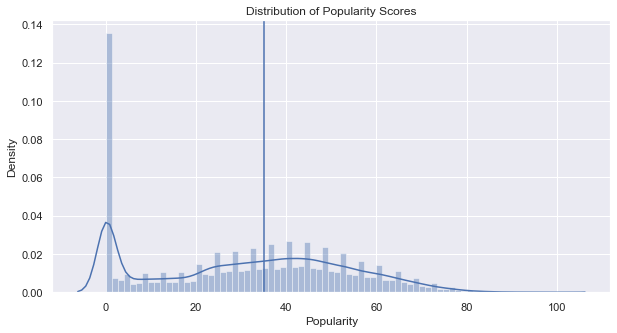

In [5]:
fig = plt.figure(figsize=(10,5))
sns.set(style="darkgrid") 
sns.distplot(df['popularity'], label="Popularity", bins='auto')
plt.xlabel("Popularity")
plt.ylabel("Density")
plt.title("Distribution of Popularity Scores")
plt.axvline(35)
plt.show()

### Create caterogrical (binary) target
In this step, I will create a new binary column named "popular". This column will have a threshold of 35. If the song popularity is greater than or equal to 35, then it will be deemed a popular song (1). Otherwise, the song is unpopular (0)

In [6]:
df['popular'] = (df['popularity'] >= 35).astype('int')
df['popular'].value_counts(1)

0    0.516838
1    0.483162
Name: popular, dtype: float64

### Make new df with necessary info

In [64]:
log_df = df[['acousticness', 'danceability', 'energy', 
          'instrumentalness', 'liveness', 'loudness', 
          'speechiness', 'valence', 'tempo', 'key', 'popular']]

In [8]:
log_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,key,popular
0,0.982,0.279,0.211,0.878000,0.665,-20.096,0.0366,0.0594,80.954,10,0
1,0.732,0.819,0.341,0.000000,0.160,-12.441,0.4150,0.9630,60.936,7,0
2,0.961,0.328,0.166,0.913000,0.101,-14.850,0.0339,0.0394,110.339,3,0
3,0.967,0.275,0.309,0.000028,0.381,-9.316,0.0354,0.1650,100.109,5,0
4,0.957,0.418,0.193,0.000002,0.229,-10.096,0.0380,0.2530,101.665,3,0


In [9]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      170653 non-null  float64
 1   danceability      170653 non-null  float64
 2   energy            170653 non-null  float64
 3   instrumentalness  170653 non-null  float64
 4   liveness          170653 non-null  float64
 5   loudness          170653 non-null  float64
 6   speechiness       170653 non-null  float64
 7   valence           170653 non-null  float64
 8   tempo             170653 non-null  float64
 9   key               170653 non-null  int64  
 10  popular           170653 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 14.3 MB


### Define X and y

In [10]:
X = log_df.drop(['popular'], axis=1)
y = log_df['popular']

### Train Test Split

In [11]:
# splitting data into training-testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42)

### Standardize train and test sets

In [12]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [13]:
# check for class imbalance
print(y_train.value_counts()) 

0    66131
1    61858
Name: popular, dtype: int64


### Fit model

In [42]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [62]:
logreg = LogisticRegressionCV(fit_intercept=True) #C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log.C_

array([2.7825594])

In [63]:
model_log.intercept_

array([1.61614416])

In [59]:
coeffs = pd.Series(model_log.coef_[0], index=X_train.columns)

In [60]:
coeffs.sort_values()

valence            -2.706813
speechiness        -2.355210
acousticness       -1.716408
liveness           -0.986410
instrumentalness   -0.685470
tempo               0.004423
key                 0.007729
loudness            0.036788
energy              1.701689
danceability        3.278855
dtype: float64

### Predict 

In [52]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

              precision    recall  f1-score   support

 Not Popular       0.76      0.77      0.76     22069
     Popular       0.75      0.74      0.75     20595

    accuracy                           0.76     42664
   macro avg       0.76      0.76      0.76     42664
weighted avg       0.76      0.76      0.76     42664



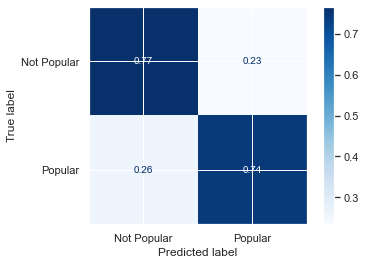

In [53]:
plot_confusion_matrix(model_log, X_test, y_test, normalize='true', cmap='Blues',
                      display_labels=['Not Popular', 'Popular'])

# Create a classification report to display evaluation metrics
print(classification_report(y_test, y_hat_test, target_names=['Not Popular', 'Popular']))

### ROC Curve and AUC

In [45]:
# Calculate the probability scores of each point in the training set
y_train_score = model_log.decision_function(X_train)


# Calculate the probability scores of each point in the test set
y_test_score = model_log.decision_function(X_test)

In [46]:
# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Calculate the fpr, tpr, and thresholds for the test set
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

#### ROC curve for training set

Training AUC: 0.8228534749667766


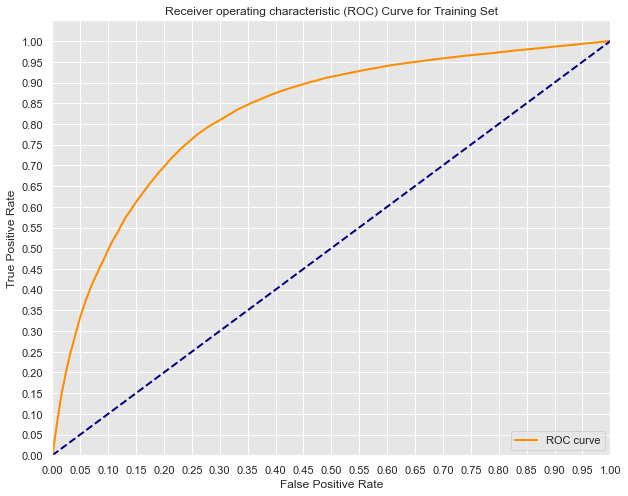

In [47]:
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

#### ROC Curve for Test Set

Test AUC: 0.8238290980623123



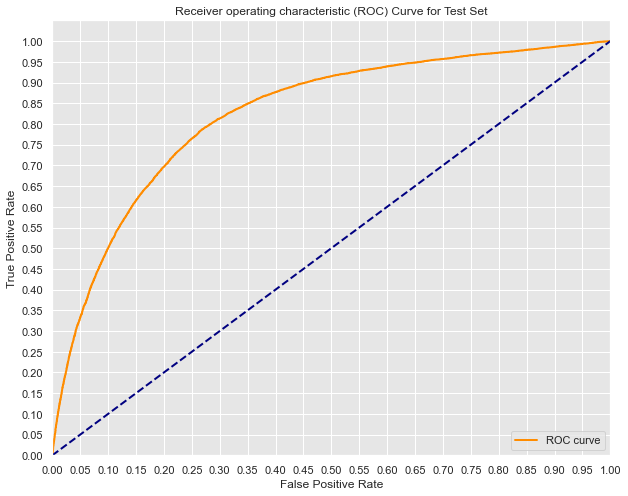

In [20]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('')
plt.show()

#### ROC Curve for Training and Test Sets

Train AUC: 0.8228576888831458
Test AUC: 0.8238290980623123


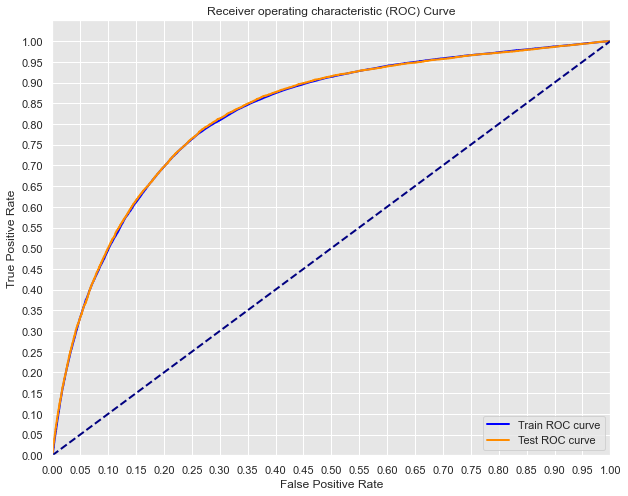

In [21]:
print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Create Confusion Matrix
The confusion matrix represents the counts (or normalized counts) of our True Positives, False Positives, True Negatives, and False Negatives.

In [22]:
# Create a confusion matrix for testing dataset
cf = confusion_matrix(y_test, y_hat_test, normalize='true').round(3)
cf

array([[0.766, 0.234],
       [0.256, 0.744]])

In [23]:
def conf_matrix(y_true, y_pred):
    cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
    
    for ind, label in enumerate(y_true):
        pred = y_pred[ind]
        if label == 1:
            # CASE: TP 
            if label == pred:
                cm['TP'] += 1
            # CASE: FN
            else:
                cm['FN'] += 1
        else:
            # CASE: TN
            if label == pred:
                cm['TN'] += 1
            # CASE: FP
            else:
                cm['FP'] += 1
    return cm

conf_matrix(y_test, y_hat_test)

{'TP': 15325, 'TN': 16907, 'FP': 5162, 'FN': 5270}

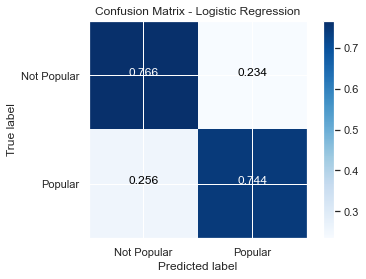

In [24]:
import itertools

plt.imshow(cf, cmap=plt.cm.Blues) 

# Add titles 
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# scale axis'
class_names = ['Not Popular', 'Popular'] 
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


thresh = cf.max() / 2. 

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], 
                 horizontalalignment='center',
                 color='white' if cf[i, j] > thresh else 'black')

plt.colorbar()
plt.show()

### Create Classification report

In [25]:
# Create a classification report to display evaluation metrics
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76     22069
           1       0.75      0.74      0.75     20595

    accuracy                           0.76     42664
   macro avg       0.76      0.76      0.76     42664
weighted avg       0.76      0.76      0.76     42664

